In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout, Input, Reshape
from tqdm import tqdm
import pickle
from sklearn.metrics import confusion_matrix,f1_score,classification_report
import matplotlib.pyplot as plt
import itertools
from sklearn.utils import shuffle
from tensorflow.keras import regularizers
from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig,TFDistilBertModel,DistilBertTokenizer,DistilBertConfig
import numpy as np
import pandas as pd
from sklearn import preprocessing 
import warnings
warnings.filterwarnings("ignore")

2021-09-14 05:30:30.721366: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
!pip install numpy requests nlpaug
import pandas as pd
import numpy as np
import nlpaug.augmenter.word as nlpaw
from tqdm import tqdm

     |████████████████████████████████| 405 kB 596 kB/s eta 0:00:01


In [3]:
def dataframe_creation():
    col_list=['Loc','Pred','Sent','Topic','Speaker','Position','Region','Party','a','b','c','d','e','Occasion']
    df_2 = pd.read_csv('../input/newsdatasets/other_dataset/other_dataset/LIAR/train.tsv',header = None,sep='\t')
    df_3 = pd.read_csv('../input/newsdatasets/other_dataset/other_dataset/LIAR/test.tsv',header = None,sep='\t')
    df_4 = pd.read_csv('../input/newsdatasets/other_dataset/other_dataset/LIAR/valid.tsv',header = None,sep='\t')
    df_1 = pd.concat([df_2,df_3,df_4])
    df_1.columns =  col_list
    return df_1

df = dataframe_creation()
print(df.columns)
le = preprocessing.LabelEncoder()
df.head()

Index(['Loc', 'Pred', 'Sent', 'Topic', 'Speaker', 'Position', 'Region',
       'Party', 'a', 'b', 'c', 'd', 'e', 'Occasion'],
      dtype='object')


,Loc,Pred,Sent,Topic,Speaker,Position,Region,Party,a,b,c,d,e,Occasion
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [4]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
X = df['Sent']
Y = df['Pred']
def maxlength(lt):
    maxi = 0
    for i in lt:
        maxi  = max(maxi, len(str(i).split()) )
    return maxi
max_len= maxlength(X)
max_len

467

In [6]:
df['Pred'].value_counts(normalize = True)

half-true      0.205379
false          0.195997
mostly-true    0.191854
barely-true    0.164412
true           0.160503
pants-fire     0.081854
Name: Pred, dtype: float64

<AxesSubplot:>

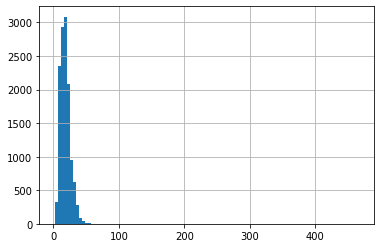

In [7]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in df['Sent']]
pd.Series(seq_len).hist(bins = 100)

In [8]:
sr = pd.Series(seq_len)
print(sr.mean())
print(sr.std())

18.040575404581347
10.129157864471994


In [5]:
X = df['Sent']
Y = df['Pred']
max_len= 28
le.fit(Y)
Y = le.transform(Y)
num_classes=  len(le.classes_)

In [6]:
def Convert(lst):
    res_dct = {i : lst[i] for i in range(0, len(lst))}
    return res_dct
classes = Convert(le.classes_)

# Transfer Learning

In [7]:
from tqdm.notebook import tqdm
from transformers import BertTokenizer, TFBertModel, TFDistilBertModel,DistilBertTokenizer , RobertaTokenizer, TFRobertaModel
#dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
#dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
#robert_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
#robert_model = TFRobertaModel.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

2021-09-14 05:31:18.464420: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-14 05:31:18.468127: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-14 05:31:18.518790: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-14 05:31:18.519813: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-14 05:31:18.519909: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-14 05:31:18.544486: I tensorflow/stream_executor/platform/def

In [8]:
def data_creation(X,Y,token):
    input_ids=[]
    attention_masks=[]
    for sent in tqdm(X):
        dbert_inps=token.encode_plus(str(sent),add_special_tokens = True,max_length =max_len,pad_to_max_length = True,return_attention_mask = True,truncation=True)
        input_ids.append(dbert_inps['input_ids'])
        attention_masks.append(dbert_inps['attention_mask'])

    input_ids=np.asarray(input_ids)
    attention_masks=np.array(attention_masks)
    Y=np.array(Y)
    print(len(input_ids),len(attention_masks),len(Y))
    return input_ids,attention_masks,Y

In [9]:
model_use = bert_model
token_use = bert_tokenizer
input_ids,attention_masks,Y = data_creation(X,Y,token_use)

  0%|          | 0/12791 [00:00<?, ?it/s]

12791 12791 12791


In [10]:
from tensorflow.keras.layers import LSTM,add
from tensorflow.keras.layers import Flatten , Conv1D
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten , Conv1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D,MaxPooling1D
from tensorflow.keras.utils import plot_model
def create_model(max_len,num_classes,mod):
    inps = Input(shape = (max_len,), dtype='int64')
    masks= Input(shape = (max_len,), dtype='int64')
    dbert_layer = mod(inps, attention_mask=masks)[0][:,0,:]
    dense = Dense(4096,activation='relu',kernel_regularizer=regularizers.l2(0.01))(dbert_layer)
    dense = Reshape(( 256 , 16))(dense)
    head4 = Conv1D(36,5)(dense)
    head4 = MaxPooling1D(5,padding='same')(head4)
    head4 = Flatten()(head4)
    dropout= Dropout(0.5)(head4)
    pred = Dense(num_classes, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)
    model = tf.keras.Model(inputs=[inps,masks], outputs=pred)
    return model

In [11]:
model = create_model(max_len,num_classes,model_use)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 28)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 768)          0           tf_bert_model[0][0]          

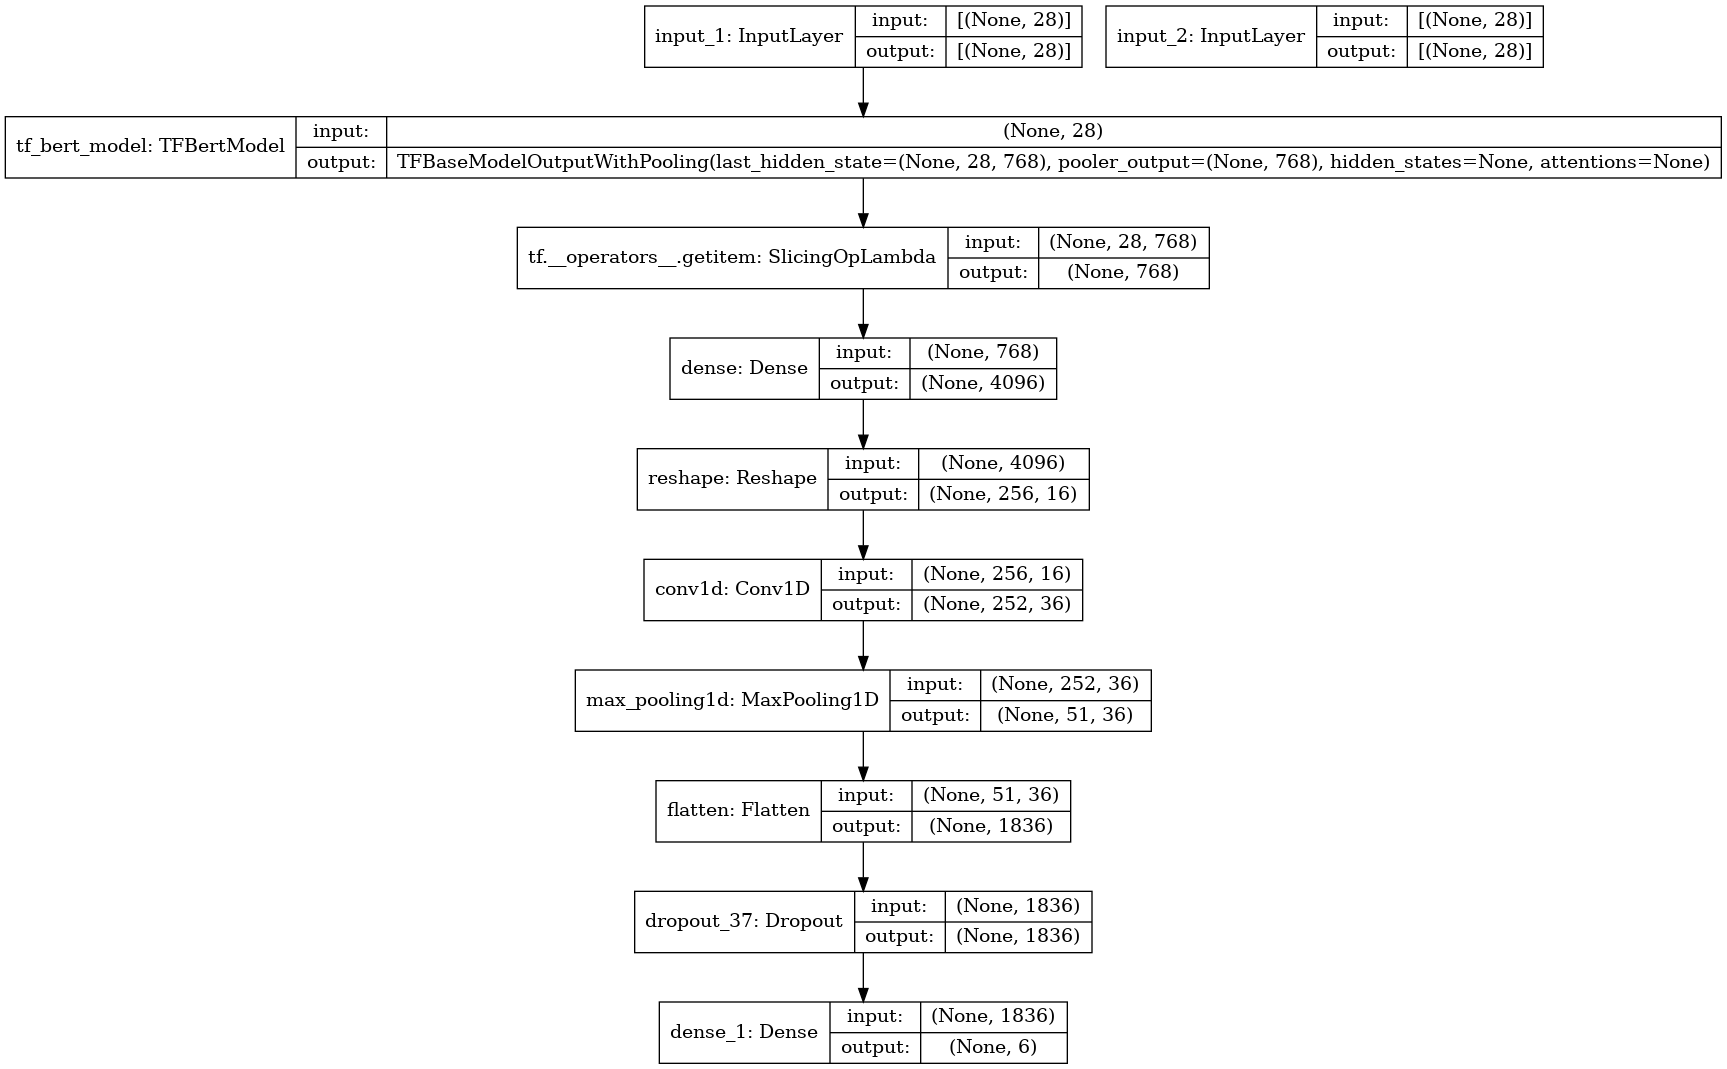

In [17]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes=True)

In [12]:
print('Preparing the pickle file.....')

pickle_inp_path='dbert_inp.pkl'
pickle_mask_path='dbert_mask.pkl'
pickle_Pred_path='dbert_Pred.pkl'

pickle.dump((input_ids),open(pickle_inp_path,'wb'))
pickle.dump((attention_masks),open(pickle_mask_path,'wb'))
pickle.dump((Y),open(pickle_Pred_path,'wb'))


print('Pickle files saved as ',pickle_inp_path,pickle_mask_path,pickle_Pred_path)

Preparing the pickle file.....
Pickle files saved as  dbert_inp.pkl dbert_mask.pkl dbert_Pred.pkl


In [13]:
print('Loading the saved pickle files..')

input_ids=pickle.load(open(pickle_inp_path, 'rb'))
attention_masks=pickle.load(open(pickle_mask_path, 'rb'))
Preds=pickle.load(open(pickle_Pred_path, 'rb'))

print('Input shape {} Attention mask shape {} Input Pred shape {}'.format(input_ids.shape,attention_masks.shape,Preds.shape))

Loading the saved pickle files..
Input shape (12791, 28) Attention mask shape (12791, 28) Input Pred shape (12791,)


In [14]:
Pred_class_dict=classes
target_names=Pred_class_dict.values()

# Splitting at 70 : 20 : 10 for Train : Test : Validation

In [18]:
train_inp,test_inp,train_Pred,test_Pred,train_mask,test_mask=train_test_split(input_ids,Preds,attention_masks,test_size=0.3)
test_inp,valid_inp,test_Pred,valid_Pred,test_mask,valid_mask=train_test_split(test_inp,test_Pred,test_mask,test_size=0.35)

print('Train inp shape {} Test input shape {} Valid input shape {}\nTrain Pred shape {} Test Pred shape {} Valid pred shape {}\nTrain attention mask shape {} Test attention mask shape {} Valid mask shape {}'.format(train_inp.shape,test_inp.shape,valid_inp.shape,train_Pred.shape,test_Pred.shape,valid_Pred.shape,train_mask.shape,test_mask.shape,valid_mask.shape))



Train inp shape (8953, 28) Test input shape (2494, 28) Valid input shape (1344, 28)
Train Pred shape (8953,) Test Pred shape (2494,) Valid pred shape (1344,)
Train attention mask shape (8953, 28) Test attention mask shape (2494, 28) Valid mask shape (1344, 28)


In [19]:

log_dir='dbert_model'
model_save_path='./dbert_model.h5'

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

model.compile(loss=loss,optimizer=optimizer, metrics=[metric])

In [20]:
history=model.fit([train_inp,train_mask],train_Pred,batch_size=64,epochs=10,validation_data=([valid_inp,valid_mask],valid_Pred))

2021-09-14 05:32:22.546604: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-14 05:32:22.556058: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000179999 Hz
2021-09-14 05:32:22.729126: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


Epoch 1/10
200/200 [==============================] - 76s 353ms/step - loss: 13.8665 - accuracy: 0.2063 - val_loss: 11.0169 - val_accuracy: 0.3006
Epoch 2/10
200/200 [==============================] - 71s 355ms/step - loss: 10.2694 - accuracy: 0.2654 - val_loss: 8.1652 - val_accuracy: 0.3787
Epoch 3/10
200/200 [==============================] - 71s 356ms/step - loss: 7.6629 - accuracy: 0.3381 - val_loss: 6.0208 - val_accuracy: 0.5417
Epoch 4/10
200/200 [==============================] - 71s 356ms/step - loss: 5.7356 - accuracy: 0.4650 - val_loss: 4.4433 - val_accuracy: 0.6644
Epoch 5/10
200/200 [==============================] - 71s 355ms/step - loss: 4.2500 - accuracy: 0.6329 - val_loss: 3.2400 - val_accuracy: 0.8296
Epoch 6/10
200/200 [==============================] - 71s 355ms/step - loss: 3.1644 - accuracy: 0.7558 - val_loss: 2.4101 - val_accuracy: 0.8698
Epoch 7/10
200/200 [==============================] - 71s 353ms/step - loss: 2.3688 - accuracy: 0.8414 - val_loss: 1.7430 - val

## Evaluation

In [22]:
preds = model.predict([test_inp,test_mask],batch_size=64)
pred_Preds = preds.argmax(axis=1)
target_names=le.classes_
print('Classification Report')
print(classification_report(test_Pred,pred_Preds,target_names=target_names))
print('Training and saving built model.....')

Classification Report
              precision    recall  f1-score   support

 barely-true       0.98      0.99      0.98       414
       false       0.99      1.00      0.99       496
   half-true       1.00      0.96      0.98       490
 mostly-true       0.98      0.95      0.96       469
  pants-fire       0.99      0.98      0.98       202
        true       0.94      1.00      0.97       423

    accuracy                           0.98      2494
   macro avg       0.98      0.98      0.98      2494
weighted avg       0.98      0.98      0.98      2494

Training and saving built model.....


# Create Test from test data and remove non corpus words

In [23]:
col_list=['Loc','Pred','Sent','Topic','Speaker','Position','Region','Party','a','b','c','d','e','Occasion']
dfT = pd.read_csv('../input/newsdatasets/other_dataset/other_dataset/LIAR/test.tsv',header = None,sep='\t')
dfT.columns =  col_list
print(dfT.shape)
dfT.head()

(1267, 14)


,Loc,Pred,Sent,Topic,Speaker,Position,Region,Party,a,b,c,d,e,Occasion
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video


In [24]:
Xt = dfT['Sent']
Yt = dfT['Pred']
Yt = le.transform(Yt)

<AxesSubplot:>

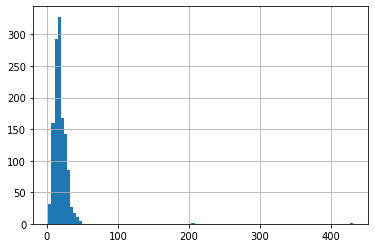

In [25]:
seq_len = [len(i.split()) for i in dfT['Sent']]
pd.Series(seq_len).hist(bins = 100)

In [26]:
sr = pd.Series(seq_len)
print(sr.mean())
print(sr.std())

18.40410418310971
14.892534964751322


In [27]:
Tid,Tm,Tp = data_creation(Xt,Yt,token_use)

  0%|          | 0/1267 [00:00<?, ?it/s]

1267 1267 1267


In [28]:
preds = model.predict([Tid,Tm],batch_size=16)
pred_Preds = preds.argmax(axis=1)
target_names=le.classes_
print('Classification Report')
print(classification_report(Tp,pred_Preds,target_names=target_names))
print('Training and saving built model.....')

Classification Report
              precision    recall  f1-score   support

 barely-true       0.98      1.00      0.99       212
       false       0.98      1.00      0.99       249
   half-true       1.00      0.95      0.97       265
 mostly-true       0.98      0.95      0.97       241
  pants-fire       0.99      0.99      0.99        92
        true       0.95      1.00      0.97       208

    accuracy                           0.98      1267
   macro avg       0.98      0.98      0.98      1267
weighted avg       0.98      0.98      0.98      1267

Training and saving built model.....
